# Chapter 5: Pretraining on unlabeled data

<h4>

In this chapter we implement a training function and pretrain the LLM. We learn about model evaluation techniques, a requirement for optimizing the LLM during the training process, and we how to load pretrained weights into our LLM


<div style="max-width:750px">
    
![](images/5.0_1.png)

</div>

    
</h4>

## 5.1 Evaluating generative text models

<h4>

This figure shows the topics covered in this chapter, and what this section will cover

<div style="max-width:600px">
    
![](images/5.1_1.png)

</div>

    
</h4>

### 5.1.1 Using GPT to generate text

In [88]:
import torch

In [89]:
import previous_chapters
from previous_chapters import GPTModel

In [90]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
print("")

<h4>

We will introduce two functions:

1. text_to_token_ids
2. token_ids_to_text

These functions will handle the conversions between text and token_ids throughout the chapter

<div style="max-width:700px">
    
![](images/5.1_2.png)

</div>



    
</h4>

In [91]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [92]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


<h4>

Model is still only producing gibberish because it has not yet been trained. To define what makes text coherent, we must implement a numerical method to evaluate the generated content, allowing us to monitor and enhance the model's performance during training.

We will calculate a <i>loss metric</i> for generated outputs. This metric is an indicator of model training progress and success.

    
</h4>

### 5.1.2 Calculating the text generation loss

<h4>

The overall flow from input text to LLM-generated text is illustrated in this five step procedure.

<div style="max-width:700px">
    
![](images/5.1_3.png)

</div>

We need to perform these initial steps before we can compute a loss that measures the generated text quality.
    
</h4>

In [93]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

# targets are the inputs but shifted one position forward

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [94]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [95]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


<h4>

We now want to evaluate the performance of the model's generated text numerically via a loss function.

Using the loss function, we measure how far the target values are from the generated tokens (predicted values) and adjust the weight parameters to generate text that is more similar (matches) the target text.



<div style="max-width:650px">
    
![](images/5.1_4.png)

</div>


    
</h4>

In [96]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


<h4>

The goal of training is to increase the probability of the correct token relative to the other tokens, this way we ensure that the LLM consistently picks the correct next token as the one it generates.

This image describes the main steps in calculating the loss for the probability scores of input batches

<div style="max-width:600px">
    
![](images/5.1_5.png)

</div>

    
</h4>

In [97]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [98]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


<h4>
We want to get the average log probability as close to 0, but in deep learning we dont want to push the log probability up to 0, rather, bring the negative average log probability down to 0. Thats why we calculate the negative average at the end.
    
</h4>

In [99]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


<h4>

This is known as <b>Cross Entropy Loss</b>

This is a popular measure in machine learning that measures the difference between two probability distributions - the true label and the predicted label.

In context of frameworks like PyTorch, the cross_entropy function computes this measure for discrete outcomes.
    
</h4>

In [100]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [101]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<h4>

Previously, we applied the softmax function to the logits and selected the probability scores corresponding to our target IDs, and computed the negative average log probability, but the cross_entropy function takes care of all that.
    
</h4>

In [102]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### 5.1.3 Calculating the training and validation set loss

<h4>

We will first prepare the training and validation datasets that will be used to train our LLM. Then we can calculat the cross entropy loss for the training and validation sets to see how the model is learning.

<div style="max-width:650px">
    
![](images/5.1_6.png)

</div>

To compute the loss on training/validation datasets, we will use a very small text dataset, "The Veridct", a short story we previously tokenized in chapter 2.
    
</h4>

In [103]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

In [104]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


<h4>

The dataset is small, but it is just for educational purpose. We want to be able to pretrain our model in a couple of minutes not a couple of weeks.

<div style="max-width:700px">
    
![](images/5.1_7.png)

</div>

The figure illustrates the process.

1. Split input text into training and validation portions
2. Tokenize the text
3. Divide the tokenized text into chunks of user-specified length
4. Shuffle the rows and organize the chunked text into batches for model training

    
</h4>

In [105]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print(split_idx)

18431


In [106]:
from previous_chapters import create_dataloader_v1

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

'''
Question:
In this dataloader, we shuffle batches of input meaning that text we are using to pretrain the LLM is not being fed to the model in order, yes the sequences of len=context_length are in order, but the batches of these sequences are not. Why would we do this? How does this help training, arent we runing the temporal ordering of words by doing this?
'''

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [107]:
print("Train Loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nVal Loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Val Loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [108]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [109]:
'''
Can use the previous utility function (computes loss for a single batch) in the proceeding function that computes the loss over all batches in a dataloader.
'''

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

<h4>

The calc_loss_loader will iterate through specified num_batches or all batches in the dataloader, accumulate the loss in the total_loss variable, and then compute the average loss over the total number of batches
    
</h4>

In [110]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # mps for apple M_ chips
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training Loss:", train_loss)
print("\nValidation Loss:", val_loss)

Training Loss: tensor(10.9876, device='mps:0')

Validation Loss: tensor(10.9811, device='mps:0')


<h4>

Now that we have a way to measure the quality of generated text, we will train the LLM to reduce this loss so that it becomes better at generating text

<div style="max-width:700px">
    
![](images/5.1_8.png)

</div>

    
</h4>

## 5.2 Training an LLM

<h4>

We now implement the code for pretraining an LLM

<div style="max-width:600px">
    
![](images/5.2_1.png)

</div>

The image illustrates the typical eight step process that we go through when training a neural network in PyTorch

    
</h4>

In [111]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] # initializes lists to track losses and tokens seen
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs): # starts the main training loop
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # resets loss gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # calculates loss gradients
            optimizer.step() # updates model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: # optional evaluation step
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context) # prints a sample text after each epoch

    return train_losses, val_losses, track_tokens_seen

<h4>

Note that this function uses two functions that have not yet been defined:

1. evaluate_model()
2. generate_and_print_sample()

The evaluate model function will print the training and validation set losses after each model update so we can evaluate whether the training improves the model. It will do this while the model is in eval mode to prevent gradient tracking and disable dropout when calculating the loss.
    
</h4>

In [112]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout is disabled during evaluation for stable, reproducible results
    with torch.no_grad(): # prevents gradient tracking (not needed during evaluation) to reduce computational overhead
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

<h4>

The generate_and_print_sample function is a convenience function we can use to track the models improvement in generating text as it continues to train. 

It takes a text snippet (start_context) as input, converts it to token IDs, and feeds it to the LLM to generate a text sample
    
</h4>

In [113]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
    model.train()

In [114]:
torch.manual_seed(123)
torch.mps.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) # .parameters() method returns all trainable weight parameters of the model
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

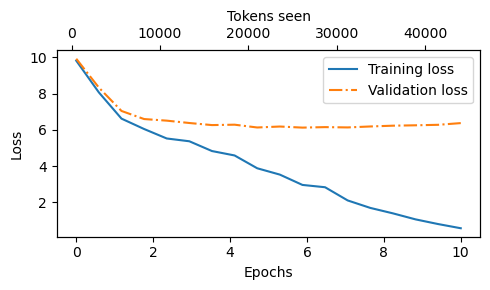

In [115]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

train_losses = [l.cpu() for l in train_losses]
val_losses = [l.cpu() for l in val_losses]

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<h4>

As we can see, the training and validation loss start to decrease after the first epoch, but they start to diverge after the second epoch. The fact that the validation loss is much larger than the training loss is evidence of the model overfitting on the training data. We can confirm that the model is memorizing training data verbatim by searching for generated text snippets, such as "quite insensible to the irony" in "The Verdict" text file.

<div style="max-width:600px">
    
![](images/5.2_2.png)

</div>

Next, we will cover different strategies for text generation for LLMs to reduce training data memorization and increase the originality of the LLM-generated text. 

</h4>

## 5.3 Decoding strategies to control randomness

<h4>

In this section we will look at text generation strategies to generate more original text.
    
</h4>

In [121]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids, tokenizer).replace("\n", " "))

Output text:
 Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  


<h4>

The generated token is selected at each generation step corresponding to the largest probability score among all tokens in the vocabulary. This means the LLM will always generate the same outputs even if we run the preceding generate_text_simple multitple times on the same start context
    
</h4>

### 5.3.1 Temperature scaling

<h4>

Lets take a look at <b>temperature scaling</b>, a sampling method that adds a probabilistic selection process to the next-token generation task.

Previously, we used torch.argmax() to select the next token to be generated by selecting the word with the highest probability, also known as <i>greedy encoding</i>. To generate text with more variety, we can replace argmax with a function that samples from a probability distribution.

Lets illustrate the probabilistic sampling with the following example
</h4>

In [122]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

In [123]:
# Assume the LLM is given the start context "Every effort moves you", and generates the following next-token logits

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [124]:
# this is how it works in the generate_text_simple function

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


<h4>

Since the largest probability is in index 3, the generated word is "forward".

To implement a probabilistic sampling process, we can replace argmax with multinomial.

</h4>

In [125]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


<h4>

The multinomial function will sample the next token proportional to its probability score, so "forward" is still the most likely word to be chosen, but it will not always choose it.
    
</h4>

In [127]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample=[torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


<h4>
    
As you can see, the word "forward" is sampled a majority of the time but there are also times where other words such as "closer" and "toward" are sampled aswell. 

We can also use a concept called temperature scaling to further control the distribution and selection process. Temperature scaling is the act of dividing the logits by parameter T, where T is a number greater than 0.

When T is close to 1, the distribution does not change much. 

When T is closer to 0, the larger the scores being passed into the softmax (recall that softmax pushes higher values to 1 and lower values to 0). Therefore, when larger values are passed to softmax the result is a distribution with increased probabilities of the most high probability words and decreased probabilities of the lower probability words.

When T is larger than 1, the result is more uniformly distributed token probabilities

</h4>

In [128]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

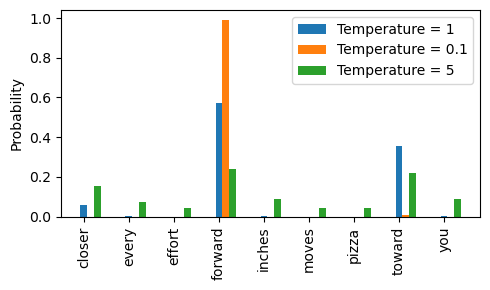

In [129]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2 Top-k sampling

<h4>

<i>Top-k sampling</i>, when combined with probabilistic sampling and temperature scaling, can improve text generation results. 

1. Choose in advance, a number of words k
2. Keep the logit values of the k tokens with the largest values, and replace all others with -inf
3. Apply softmax to get a legitimate probability distribution
4. Randomly sample a word from within these remaining k most-probable words according to its probability

<div style="max-width:700px">
    
![](images/5.3_1.png)

</div>
    
</h4>

In [131]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits) # logit values
print("Top pos:", top_pos) # token Ids

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top pos: tensor([3, 7, 0])


In [133]:
# Use PyTorch where function to set the logit values of the tokens that are below the lowest logit value within the top-three selection to -inf

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # identifies logits < the minimum in top-k
    input=torch.tensor(float('-inf')), # assigns -inf to these lower logits
    other=next_token_logits # retains original logits for all other tokens
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [134]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

<h4>
We can now apply temperature scaling and the multinomial function for probabilistic sampling to select the next token among these three non-zero probability scores to generate the next token
</h4>

In [135]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens): # forloop same as before: gets logits and only focuses on last time step.
        idx_cond = idx[:, -context_size:] # only use the last n (n=context_size) tokens as input to the model
        with torch.no_grad():
            logits = model(idx_cond) # logits.shape = [batch, context_size, |V|]
        logits = logits[:, -1, :] # get the 1 x |V| vector for the last word in the input (context_size[-1])
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id: # stops generating early if end-of-sequence token is encountered
            break
        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

In [144]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=5,
    temperature=2
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you can remember work on that my hostess: "interesting": on that point


## 5.4 Loading and saving model weights in PyTorch

<h4>

We have demonstrated how computationally (and time) expensive pretraining an LLM is. Thus, it is important that we can save the LLM so we do not have to rerun the training every time we want to use it in a new session.

Lets discuss how to save and load a pretrained model.

<div style="max-width:600px">
    
![](images/5.4_1.png)

</div>

</h4>

<h4>
Saving a model is relatively straightforward in PyTorch. Generally, we save a models <i>state dict</i>, a dictionary mapping each layer to its parameters, using the torch.save function.
</h4>

In [145]:
torch.save(model.state_dict(), "model.pth")

<h4>
After saving a model, we can load the model weights into a new GPTModel instance
</h4>

In [149]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()
print("")

/var/folders/hj/q7z2__rx1m14p2t84cn3s7xr0000gn/T/ipykernel_44672/879948430.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", 

<h4>
If we want to continue pretraining the model later, after saving, saving the optimizer state is also recommended. Adaptive optimizer (like AdamW) save additional parameters for each model weight. Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge.
</h4>

In [150]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
            }, 
    "model_and_optimizer.pth")

<h4>
Then, we can restore and load both the model and optimizer states by first loading the saved data with torch.load, then using the load_state_dict method
</h4>

In [152]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()
print("")

/var/folders/hj/q7z2__rx1m14p2t84cn3s7xr0000gn/T/ipykernel_44672/2865937130.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.

## 5.5 Loading pretrained weights from OpenAI

<h4>

OpenAI has openly shared the weights of their GPT-2 models, thus eliminationg the need to invest tens to hundreds of thousands of dollars in retraining the model on a large corpus ourselves. 

We can load these weights into our GPTModel class and use it for text generation. <i>Weights</i> is referring to the weight parameters stored in the .weight attribute of PyTorch's Linear and Embedding layers, for example.

</h4>

<h4>
Choose Model
</h4>

In [190]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small-124M": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium-355M": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large-774M": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl-1558M": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-xl-1558M"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

<h4>
Download File
</h4>

In [191]:
import os

file_name = f"{CHOOSE_MODEL}.pth"
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

Downloaded to gpt2-xl-1558M.pth


<h4>
Load Weights
</h4>

In [192]:
gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1600, out_features=1600, bias=True)
        (W_key): Linear(in_features=1600, out_features=1600, bias=True)
        (W_value): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELU()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [194]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=5,
    context_size=BASE_CONFIG["context_length"],
    top_k=45,
    temperature=0.8
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you away from these self-
